<a href="https://colab.research.google.com/github/ryomado/waste-sorting/blob/master/waste_sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ỨNG DỤNG MÔ HÌNH CNN VÀO PHÂN LOẠI RÁC THẢI**
---
link github : https://github.com/ryomado/waste-sorting


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import shutil
import re
import seaborn as sns
#tắt mấy cái warning khi train trên colab, còn trình duyệt sẽ crash, em cũng không rõ lắm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

**Mount dữ liệu từ drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Giải nén dataset**

---



In [0]:
!unzip -q "/content/drive/My Drive/dataset-resized.zip"

Có 6 thư mục con trong dataset-resized:

In [0]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['glass', 'cardboard', 'paper', 'trash', 'plastic', '.DS_Store', 'metal']

**Sắp sếp**

---


Chia hình ảnh thành các thư mục:


*   Train: 60%
*   Validation: 20%
*   Test: 20%







In [0]:
# XÂY DỰNG HÀM CẦN THIẾT:

# chia số lượng ảnh cho các mục(train, valid, test) với cách lấy mẫu ngẫu nhiên
  # input: folder_path
  # output: train, valid and test indices
def split_indices(folder, seed1, seed2):
  n = len(os.listdir(folder))
  full_set = list(range(1, n+1))

  # train
  random.seed(seed1)
  train = random.sample(list(range(1, n+1)), int(.6*n))

  # temp
  remain = list(set(full_set)-set(train))

  # tách phần còn lại thành validation & test
  random.seed(seed2)
  valid = random.sample(remain, int(.5*len(remain)))
  test = list(set(remain)-set(valid))

  return(train, valid, test)

# trả về tên của một loại rác cụ thể, được chỉ định
  # input: loại rác và indices
  # output: file name
def get_names(waste_type, indices):
  file_names = [waste_type+str(i)+".jpg" for i in indices]
  return (file_names)

# di chuyển nhóm file sang thư mục khác
  # input: danh sách file and thư mục đích
  # no output
def move_files(source_files, destination_folder):
  for file in source_files:
    shutil.move(file, destination_folder)

Thực thi các hàm trên

In [0]:
subsets = ['train', 'valid']
waste_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# tạo thư mục đích cho data subset and waste type
for subset in subsets:
  for waste_type in waste_types:
    folder = os.path.join('data', subset, waste_type)
    if not os.path.exists(folder):
      os.makedirs(folder)

if not os.path.exists(os.path.join('data', 'test')):
  os.makedirs(os.path.join('data', 'test'))

# di chuyển các file đến thư mục đích cho từng loại rác thải
for waste_type in waste_types:
  source_folder = os.path.join('dataset-resized', waste_type)
  train_ind, valid_ind, test_ind = split_indices(source_folder, 1, 1)

  # train
  train_names = get_names(waste_type, train_ind)
  train_source_files = [os.path.join(source_folder, name) for name in train_names]
  train_dest = "data/train/"+waste_type
  move_files(train_source_files, train_dest)

  # valid
  valid_names = get_names(waste_type, valid_ind)
  valid_source_files = [os.path.join(source_folder, name) for name in valid_names]
  valid_dest = "data/valid/"+waste_type
  move_files(valid_source_files, valid_dest)

  # test
  test_names = get_names(waste_type, test_ind)
  test_source_files = [os.path.join(source_folder, name) for name in test_names]
  # để tránh hình ảnh bị lẫn lộn
  move_files(test_source_files, "data/test")

In [0]:
path = Path(os.getcwd())/"data"
#path

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test", ds_tfms=tfms, bs=16)
# Có thể đổi tham số bs nếu máy tính cấu hình thấp hơn - là số ảnh đi vô 1 lần học 

In [0]:
data

ImageDataBunch;

Train: LabelList (1514 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Valid: LabelList (505 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Test: LabelList (508 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

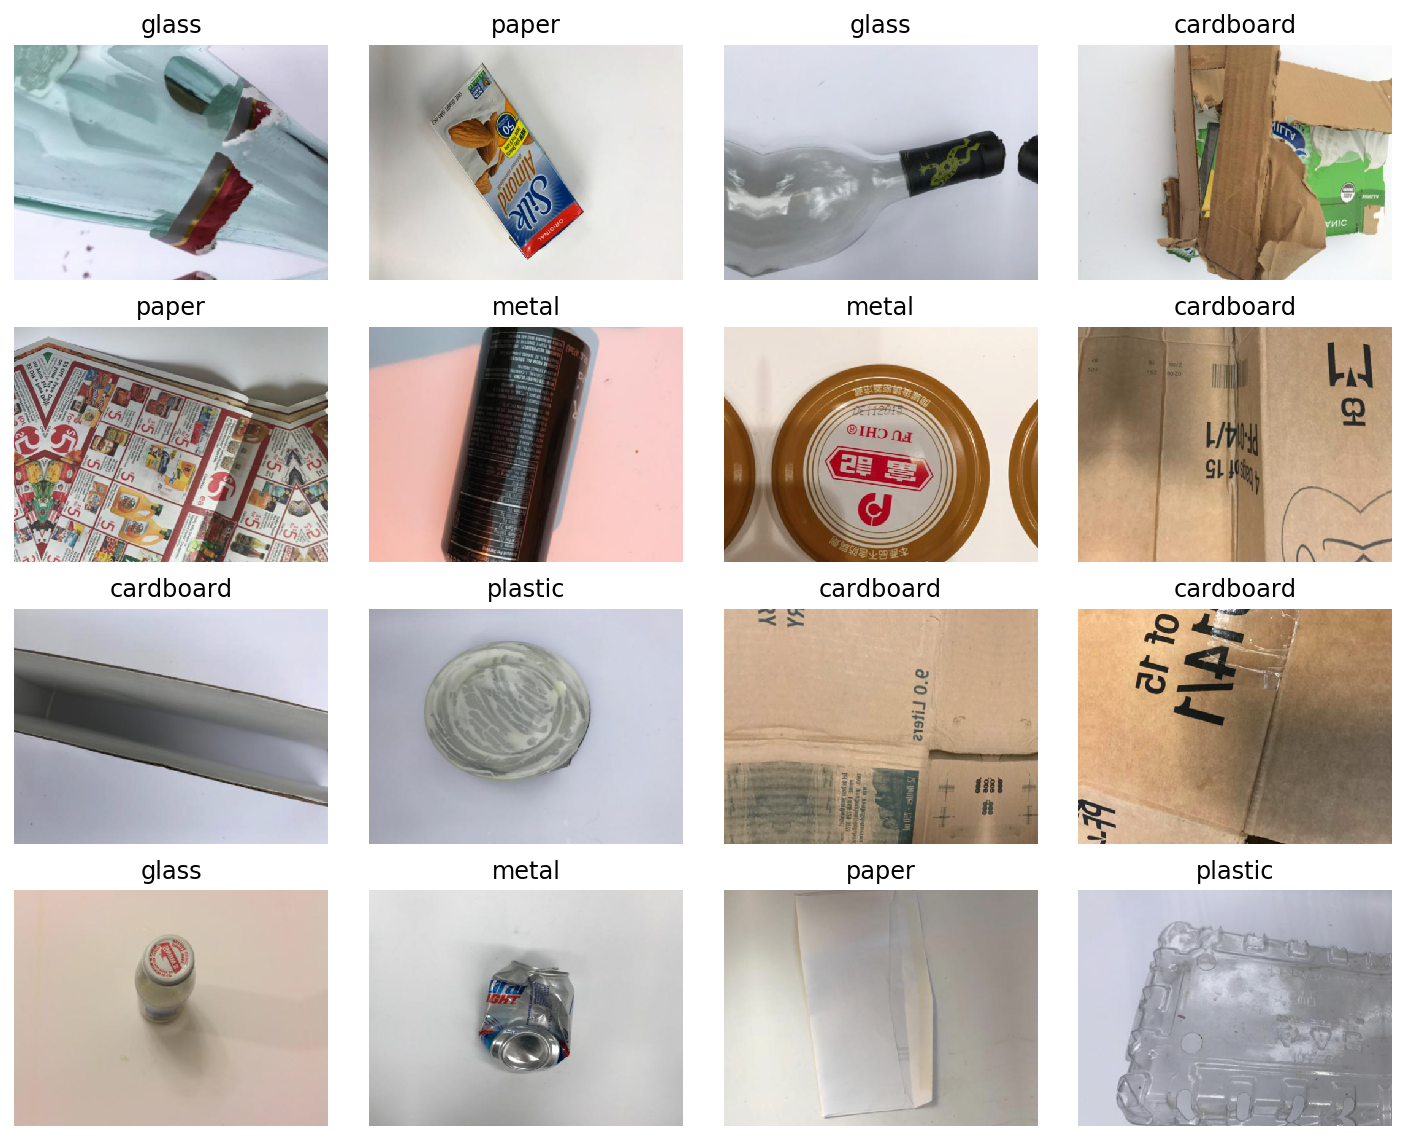

In [0]:
# xem ảnh mẫu
data.show_batch(rows=4, figsize=(10,8))

**Model training**



---



In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 287MB/s]


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

**Tìm tốc độ học tập**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.82E-04
Min loss divided by 10: 2.57E-03


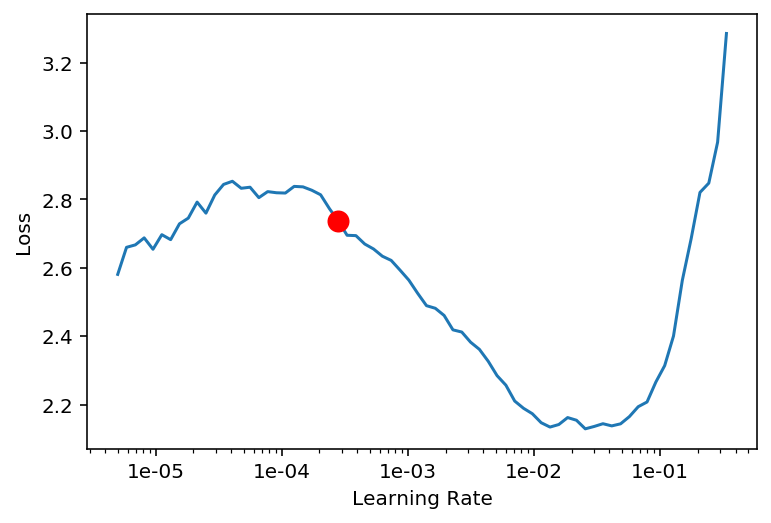

In [0]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot(suggestion=True)

Tốc độ học cũng chỉ mang tính tương đối, ta có thể lấy max_lr=5e-03 là tốc độ học tối đa trên mỗi kỷ nguyên


**Training trong 40 kỷ nguyên**

In [16]:
learn.fit_one_cycle(40, max_lr=5e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.479522,0.798767,0.279208,00:41
1,1.068723,0.550846,0.188119,00:40
2,0.868840,0.519519,0.174257,00:41
3,0.716921,0.459928,0.148515,00:41
4,0.622336,0.469531,0.162376,00:40
5,0.644039,0.422252,0.146535,00:40
6,0.667276,0.482911,0.162376,00:39
7,0.679416,0.450438,0.156436,00:39
8,0.627984,0.696100,0.174257,00:39
9,0.703471,0.502360,0.156436,00:39


Xuất model

In [0]:
learn.export('export.pkl')

Xem những hình ảnh được phân loại không chính xác:

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

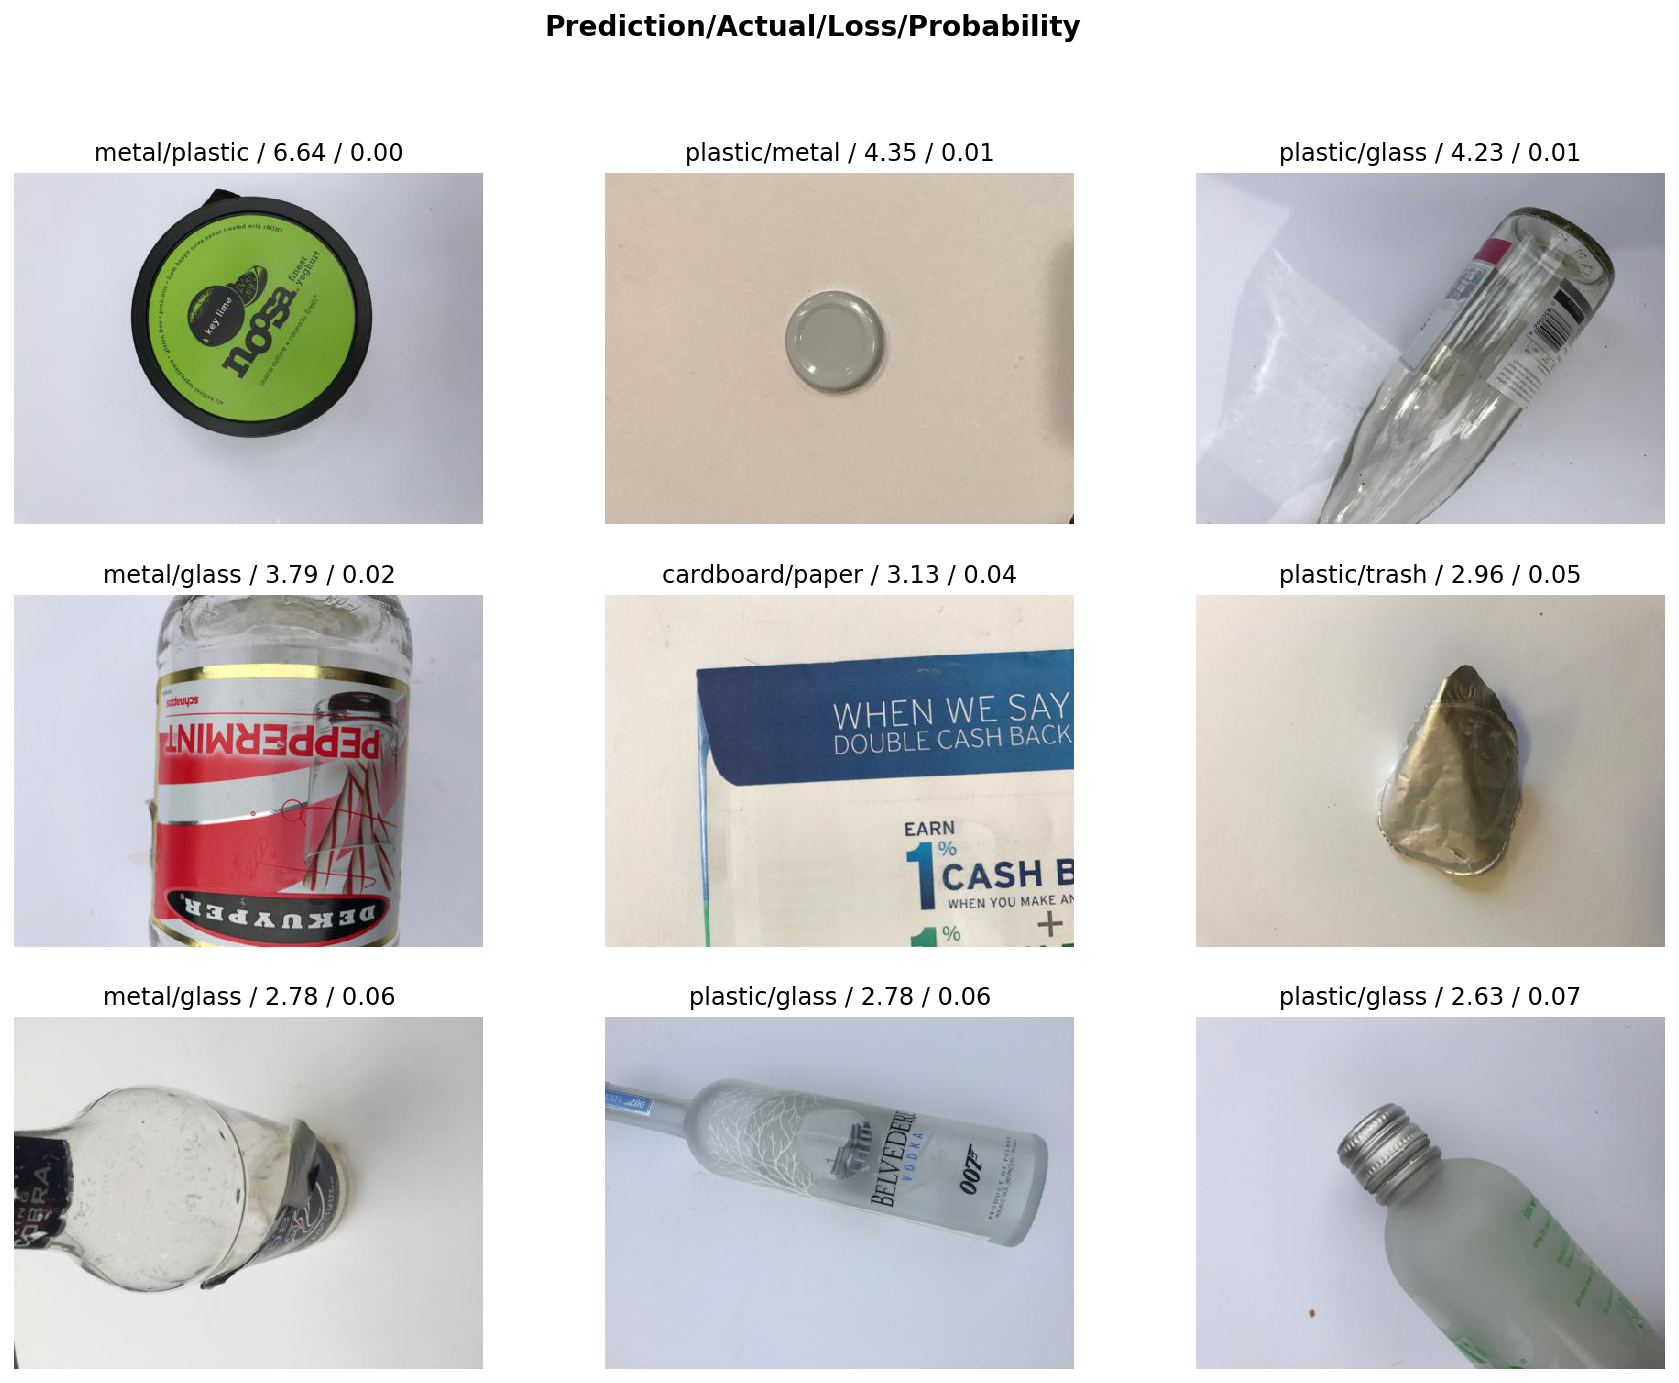

In [19]:
interp.plot_top_losses(9, figsize=(15, 11))

**Ma trận confusion**: hiển thị trực quan số lượng lỗi

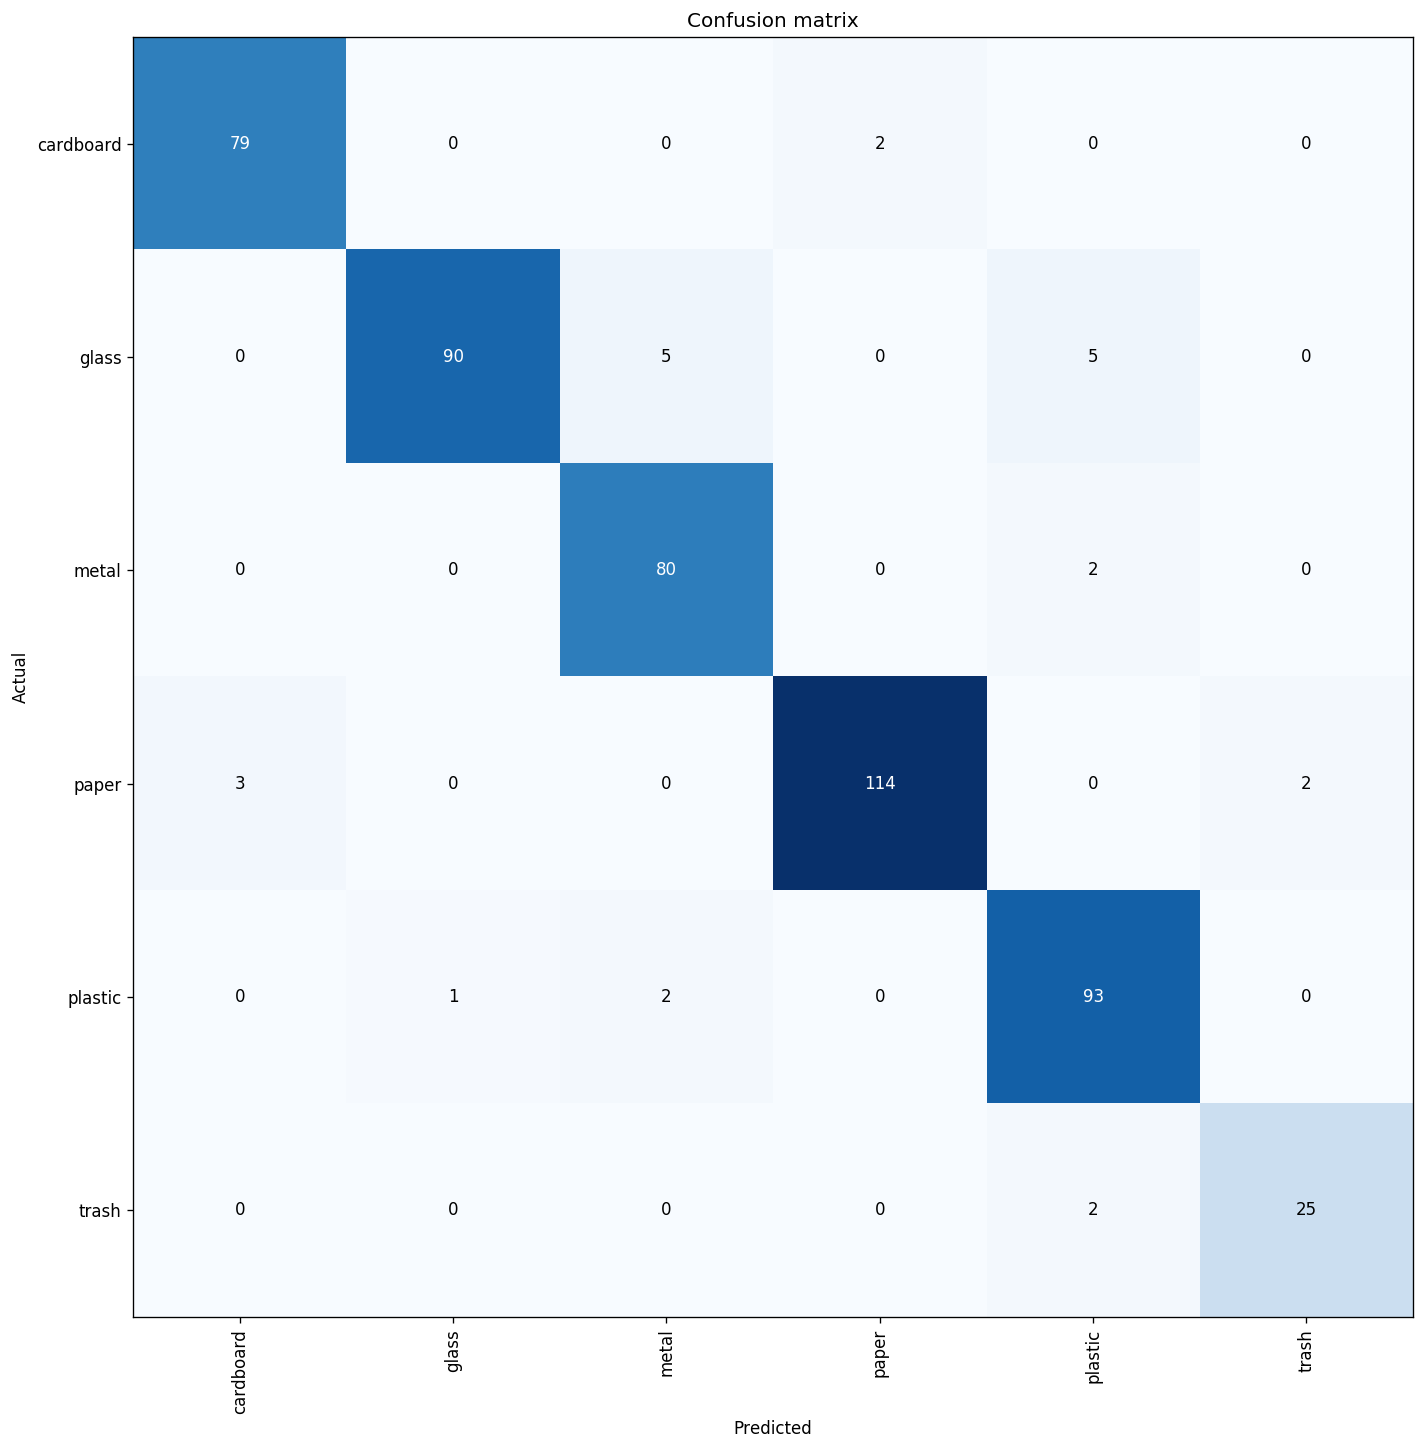

In [20]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('glass', 'metal', 5),
 ('glass', 'plastic', 5),
 ('paper', 'cardboard', 3),
 ('cardboard', 'paper', 2),
 ('metal', 'plastic', 2),
 ('paper', 'trash', 2),
 ('plastic', 'metal', 2),
 ('trash', 'plastic', 2)]

**Dự đoán trong tập dữ liệu TEST**

In [0]:
# Dự đoán trên một tập các hình ảnh
preds = learn.get_preds(ds_type=DatasetType.Test)

In [23]:
print(preds[0].shape)
preds[0]

torch.Size([508, 6])


tensor([[2.9329e-01, 3.4520e-02, 6.3891e-01, 7.6859e-04, 2.2787e-02, 9.7216e-03],
        [6.6203e-01, 2.3704e-01, 8.4483e-02, 9.9060e-03, 5.9681e-03, 5.7404e-04],
        [3.9840e-04, 2.8806e-05, 1.3775e-08, 9.9953e-01, 3.4233e-05, 1.0900e-05],
        ...,
        [1.6448e-09, 2.9804e-08, 2.7744e-06, 9.8055e-04, 6.3455e-05, 9.9895e-01],
        [1.0613e-04, 9.9727e-01, 2.1664e-03, 1.1780e-06, 1.9373e-04, 2.5965e-04],
        [2.9935e-05, 9.1088e-09, 4.7480e-08, 9.9994e-01, 1.3853e-06, 3.3370e-05]])

Đây là xác suất dự đoán cho mỗi ảnh

In [24]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

**Chuyển các xác suất thành nhãn lớp**

In [0]:
max_idxs = np.asarray(np.argmax(preds[0], axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
  yhat.append(data.classes[max_idx])

In [27]:
# show nhãn các dự đoán của tất cả hình ảnh
yhat

['metal',
 'cardboard',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'metal',
 'plastic',
 'paper',
 'plastic',
 'paper',
 'plastic',
 'paper',
 'plastic',
 'plastic',
 'cardboard',
 'metal',
 'metal',
 'metal',
 'cardboard',
 'paper',
 'cardboard',
 'metal',
 'glass',
 'plastic',
 'cardboard',
 'cardboard',
 'glass',
 'cardboard',
 'glass',
 'metal',
 'metal',
 'glass',
 'paper',
 'metal',
 'glass',
 'plastic',
 'plastic',
 'glass',
 'cardboard',
 'glass',
 'trash',
 'plastic',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'plastic',
 'trash',
 'paper',
 'glass',
 'paper',
 'glass',
 'cardboard',
 'plastic',
 'metal',
 'paper',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'plastic',
 'plastic',
 'cardboard',
 'paper',
 'glass',
 'plastic',
 'glass',
 'metal',
 'trash',
 'plastic',
 'plastic',
 'plastic',
 'paper',
 'trash',
 'paper',
 'metal',
 'cardboard',
 'plastic',
 'paper',
 'glass',
 'cardboard',
 'cardboard',
 'metal',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'trash',
 'meta

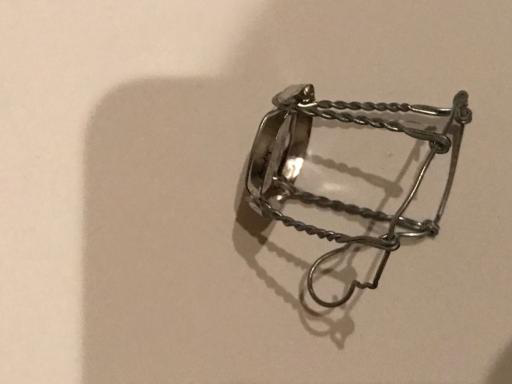

In [28]:
# kiểm tra xem hình ảnh đầu tiên có phải là kim loại không?
learn.data.test_ds[0][0]

In [0]:
#Tiếp theo, sẽ lấy các lable thực từ tập test

In [0]:
y = []
for label_path in data.test_ds.items:
  y.append(str(label_path))

pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
  y[i] = pattern.search(y[i]).group(1)

A quick check

In [0]:
# predicted values
#print(yhat[0:5])

# actual values
#print(y[0:5])

In [0]:
#learn.data.test_ds[0][0]

**Confusion matrix** sau khi dự đoán trên tập TEST

In [33]:
cm = confusion_matrix(y, yhat)
print(cm)

[[ 80   0   0   1   0   0]
 [  1  93   5   0   2   0]
 [  0   1  80   0   1   0]
 [  0   0   1 116   0   2]
 [  0   1   2   0  94   0]
 [  0   0   0   1   1  26]]


Làm đẹp ma trận

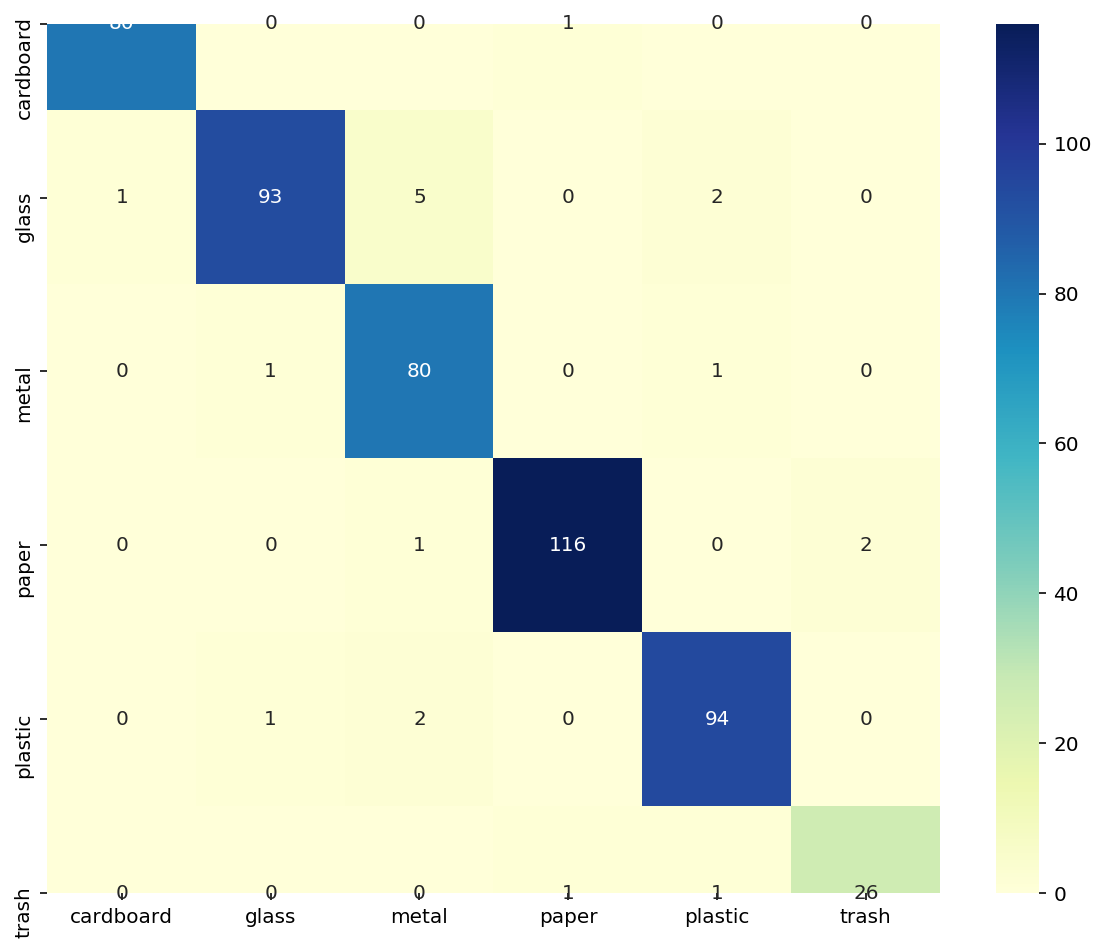

In [34]:
df_cm = pd.DataFrame(cm, waste_types, waste_types)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap= "YlGnBu")

**Độ chính xác:**

In [0]:
correct = 0

for r in range(len(cm)):
  for c in range(len(cm)):
    if(r==c):
      correct += cm[r,c]

In [36]:
accuracy = correct/sum(sum(cm))
accuracy

0.9625984251968503